In [1]:
import cv2
import numpy as np
import glob

np.set_printoptions(suppress=True)

In [3]:
# step1 找棋盘格的角点

In [14]:
def get_points(images, if_show_points,objp_zero):
    count = 0 #符合条件图片计数
    
    for fname in images:
        # 读入图片
        img = cv2.imread(fname)
        # 将图片转换为灰度图
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 找到棋盘格角点
        ret, corners = cv2.findChessboardCorners(gray, (w, h), None)
        # 如果找到足够点对，将其存储起来
        if ret == True:
            # 角点精确检测
            count += 1
            cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            # 将结果存入列表
            objpoints.append(objp_zero)
            imgpoints.append(corners)
            # 将角点在图像上显示
            cv2.drawChessboardCorners(img, (w, h), corners, ret)
            # 是否窗口展示结果
            if if_show_points:
                cv2.imshow('findCorners', img)
            # 保存包含角点的结果
            cv2.imwrite('bd_points/points_' + str(count) + '.jpg', img)
            cv2.waitKey(10)
    cv2.destroyAllWindows()
    return gray

In [15]:
# 定义搜索的阈值
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# 定义棋盘格模板规格
w = 6  
h = 4

# 定义世界坐标系中的棋盘格点 (设为0)
objp_zero = np.zeros((w * h, 3), np.float32)
objp_zero[:, :2] = np.mgrid[0:w, 0:h].T.reshape(-1, 2)

# 储存棋盘格角点的世界坐标和图像坐标对
objpoints = []  # 世界坐标系中的三维点
imgpoints = []  # 图像平面的二维点

# 遍历calibimage中的图片
images = glob.glob('calibimage/*')

# 得到棋盘格的角点：
gray = get_points(images, True, objp_zero)

In [12]:
# 根据objpoints和imgpoints计算内参和外参

In [23]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# input：世界坐标系里的位置 像素坐标 图像的像素尺寸大小 3*3矩阵，相机内参数矩阵 畸变矩阵
# output：重投影误差 内参数矩阵 畸变系数 外参数矩阵(旋转矩阵 + 平移向量)

In [24]:
# 重投影误差
print(("重投影误差:"), ret)

重投影误差: 0.2853967165200784


In [25]:
# 内参数矩阵
print(("内参数矩阵:\n"), mtx)  

内参数矩阵:
 [[875.80821861   0.         318.74229462]
 [  0.         886.78642955 228.25653634]
 [  0.           0.           1.        ]]


In [26]:
# 畸变系数 (k_1,k_2,p_1,p_2,k_3)
print("畸变系数:\n")  
print("k1: ", dist[0][0])
print("k2: ", dist[0][1])
print("p1: ", dist[0][2])
print("p2: ", dist[0][3])
print("k3: ", dist[0][4])

畸变系数:

k1:  -0.4067661800125543
k2:  -0.061603728832662304
p1:  0.0012352233941970536
p2:  -0.002438642263803446
k3:  0.9575992357100578


In [27]:
# 外参数矩阵——旋转向量
print(("外参数矩阵——旋转向量:\n"), rvecs)

外参数矩阵——旋转向量:
 (array([[ 0.16326832],
       [-0.03257553],
       [ 1.52068594]]), array([[ 0.16572197],
       [-0.03102486],
       [ 1.52064976]]), array([[-0.05180456],
       [-0.26422997],
       [ 1.45654579]]), array([[-0.45277606],
       [ 0.51991003],
       [-1.11779516]]), array([[0.11897898],
       [0.030806  ],
       [1.55922007]]), array([[ 0.18077221],
       [-0.0438073 ],
       [ 1.51729519]]), array([[ 0.17946064],
       [-0.04114183],
       [ 1.51744532]]), array([[ 0.26316503],
       [ 0.6678285 ],
       [-1.54604892]]), array([[ 0.48195769],
       [ 0.77294367],
       [-1.49943635]]))


In [28]:
# 外参数矩阵——平移向量
print(("外参数矩阵——平移向量:\n"), tvecs)

外参数矩阵——平移向量:
 (array([[ 4.82761182],
       [-2.40064501],
       [14.84500364]]), array([[ 4.79396169],
       [-2.40253764],
       [14.84852681]]), array([[ 4.64589903],
       [-2.62428665],
       [15.76022041]]), array([[ 1.05854147],
       [ 1.83707354],
       [18.65098206]]), array([[ 2.0592325 ],
       [-2.81467789],
       [24.96442936]]), array([[ 3.37732047],
       [-2.51366799],
       [14.77368577]]), array([[ 3.34720008],
       [-2.51758064],
       [14.79643777]]), array([[ 0.61068873],
       [ 2.21613667],
       [18.11275775]]), array([[ 0.91073363],
       [ 2.46818327],
       [17.73353792]]))


In [30]:
# 检验去畸变效果 (以images[0]为例)

In [31]:
images[0]

'calibimage\\left01.jpg'

In [29]:
ex_img = cv2.imread(images[0])
h, w = ex_img.shape[:2]
# 使用cv.getOptimalNewCameraMatrix()优化内参数和畸变系数，
# alpha = 0 : 只裁剪
new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0, (w, h)) 

dst = cv2.undistort(ex_img, mtx, dist, None, new_mtx)
cv2.imwrite('bd_result/calibresult.jpg', dst)

True

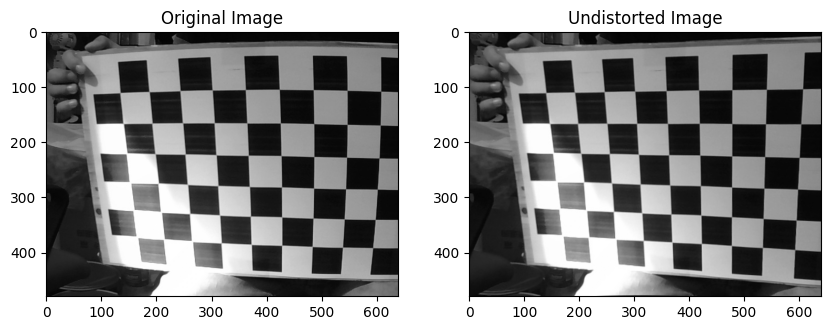

In [33]:
# 对比原图和去畸变后图：
import cv2
import matplotlib.pyplot as plt

# 读取原图和去畸变后的图像
img_orig = cv2.imread('calibimage/left01.jpg')
img_undistorted = cv2.imread('bd_result/calibresult.jpg')

# 转换图像的颜色空间（BGR -> RGB）
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_undistorted = cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2RGB)

# 创建画布，并在画布上绘制两张图像
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(img_orig)
axes[0].set_title('Original Image')
axes[1].imshow(img_undistorted)
axes[1].set_title('Undistorted Image')

# 保存图像
plt.savefig('bd_result/compare.png')

# 显示图像
plt.show()